<h1>Hospital Simulation</h1>
<h2>System 1</h2>

In [7]:
"""
Simulation Model: Multi-Department Hospital Workflow

In this phase, we aim to evaluate two different system designs to address the shortages identified in Phase 2 
All parameters remain the same as in Phase 2.1, except for the specific changes mentioned below. 
By adjusting these parameters, we will compare the performance of both systems and determine which one operates
more efficiently.
 
System 1: 
    reduction in Pre Surgery Staying ---> 32 h
    20% Pre Surgery Beds ----> 30 Beds
    37% Pre General Beds ----> 55 Beds
    
"""


'\nSimulation Model: Multi-Department Hospital Workflow\n\nIn this phase, we aim to evaluate two different system designs to address the shortages identified in Phase 2 \nAll parameters remain the same as in Phase 2.1, except for the specific changes mentioned below. \nBy adjusting these parameters, we will compare the performance of both systems and determine which one operates\nmore efficiently.\n \nSystem 1: \n    reduction in Pre Surgery Staying ---> 32 h\n    20% Pre Surgery Beds ----> 30 Beds\n    37% Pre General Beds ----> 55 Beds\n    \n'

<h2>Important Libraries</h2>

In [10]:
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import matplotlib.ticker as ticker
import scipy.stats as stats

<h2>Patient Generator Function</h2>

In [12]:
def generate_random_group(future_event_list ,data, state, clock):
    
    # urgent group arrival
    
    group_number = discrete_uniform(2, 5)
    
    if state['NBEM'] <= 10 - group_number:
        
        state['NBEM'] += group_number
        data['Cumulative Stats']['Service Starters']['Emergency'] += group_number
        
        for i in range(group_number):
            member = attribute_generator(data)
            member['Patient_Type'] = 1
            member['Group_Number'] = group_number 
            member['Arrival_Type'] = 1
            data['Patients_info'][member['Patient_Number']] = member

            e = 1e-7
            data['Patients']['Emergency_arrival'][member['Patient_Number']] = clock + i * e
            data['Patients']['Emergency service begins'][member['Patient_Number']] = clock + i * e
            fel_maker(future_event_list, event_type='lab_arrival', clock=clock + i * e, patient=member)
            
        #generate_random_group(future_event_list, data, state, clock)                
    
    else:
        #generate_random_group(future_event_list, data, state, clock)       
        state['ND'] += group_number


<h2>Attribute Generator Function</h2>

In [14]:
def attribute_generator(data):
    attributes = {}

    # patient number
    attributes['Patient_Number'] = len(data['Patients_info']) + 1

    # patient type

    attributes['Patient_Type'] = 0

    # surgery type
    surgery_type = ['S', 'M', 'C']
    surgery_probabilities = [0.5, 0.45, 0.05]
    attributes['Surgery_Type'] = random.choices(surgery_type, surgery_probabilities)[0]

    # Complex surgery type
    if attributes['Surgery_Type'] == 'C':
        complex_type = ['CC', 'CU']
        complex_type_probabilities = [0.25, 0.75]
        attributes['Complex_Type'] = random.choices(complex_type, complex_type_probabilities)[0]
    else:
        attributes['Complex_Type'] = 0

    # part
    if attributes['Surgery_Type'] == 'M':
        part = ['ICU', 'CCU', 'G']
        part_probabilities = [0.1, 0.2, 0.7]
        attributes['Part'] = random.choices(part, part_probabilities)[0]
    elif attributes['Surgery_Type'] == 'S':
        attributes['Part'] = 'G'
    else:
        attributes['Part'] = 'ICU' if attributes['Complex_Type'] == 'CU' else 'CCU'


    attributes['Arrival_Type'] = 0
    attributes['Group_Number'] = 0

    # last part default
    attributes['Last_Part'] = ''

    return attributes


In [15]:
def define_part(part):
    if part == 'G':
        event_type = 'General_arrival'
    elif part == 'ICU':
        event_type = 'ICU_arrival'
    else:
        event_type = 'CCU_arrival'
    return event_type


<h2>Starting State Function</h2>

In [21]:
def starting_state():
    # State variables
    state = dict()
    state['NQA'] = 0                       # 1-Number of Patients in reservation Queue
    state['NQL'] = 0                       # 2-Number of Non_Urgent Patients in Lab Queue
    state['NUQL'] = 0                      # 3-Number of Urgent Patients in Lab Queue
    state['NUQOR'] = 0                     # 4-Number of Urgent Patients in OR Queue
    state['NQOR'] = 0                      # 5-Number of Non_Urgent Patients in OR Queue
    state['NQCCU'] = 0                     # 6-Number of Patients in CCU Queue
    state['NQICU'] = 0                     # 7-Number of Patients in ICU Queue
    state['NQG'] = 0                       # 8-Number of Patients in General Queue
    state['ND'] = 0                        # 9-Number of leaving Patients in the emergency
    state['NDE'] = 0                       # 10-Number of Dead Patients
    state['NL'] = 0                        # 11-Number of Non_Urgent Patients being served in the lab
    state['NUL'] = 0                       # 12-Number of Urgent Patients being served in the lab
    state['NOR'] = 0                       # 13-Number of Non_Urgent Patients being served in the OR
    state['NUOR'] = 0                      # 14-Number of Urgent Patients being served in the OR
    state['NBPreS'] = 0                    # 15-Number of occupied beds in PreSurgery
    state['NBEM'] = 0                      # 16-Number of occupied beds in emergency room
    state['NBAM'] = 0                      # 17-Number of occupied beds in Ambulance
    state['NBL'] = 0                       # 18-Number of occupied beds in lab
    state['NBOR'] = 0                      # 19-Number of occupied beds in OR
    state['NBCCU'] = 0                     # 20-Number of occupied beds in CCU
    state['NBICU'] = 0                     # 21-Number of occupied beds in ICU
    state['NBG'] = 0                       # 22-Number of occupied beds in General
    state['NES'] = 0                       # 23-Number of served patients
    state['Available_ICU'] = 10            # 24-Number of available beds in CCU due to electricity
    state['Available_CCU'] = 5             # 25-Number of available beds in CCU due to electricity
    state['Reoperation_times'] = 0         # 26-Number of patients who needs reoperation
    state['total_complex_surgery'] = 0     # 27-Number of patients who have had complex surgery

    # saving data
    data = dict()

    data['Last Time Queue Length Changed'] = dict()
    data['Last Time Queue Length Changed']['Emergency Queue'] = 0
    data['Last Time Queue Length Changed']['Reservation Queue'] = 0
    data['Last Time Queue Length Changed']['Non_Urgent Patients in Lab Queue'] = 0
    data['Last Time Queue Length Changed']['Urgent Patients in Lab Queue'] = 0
    data['Last Time Queue Length Changed']['Urgent Patients in OR Queue'] = 0
    data['Last Time Queue Length Changed']['Non_Urgent Patients in OR Queue'] = 0
    data['Last Time Queue Length Changed']['Patients in CCU Queue'] = 0
    data['Last Time Queue Length Changed']['Patients in ICU Queue'] = 0
    data['Last Time Queue Length Changed']['Patients in General Queue'] = 0

    # store all users' data in each queue
    data['Queue Patients'] = dict()
    data['Queue Patients']['Emergency Queue'] = dict()
    data['Queue Patients']['Reservation Queue'] = dict()
    data['Queue Patients']['Non_Urgent Patients in Lab Queue'] = dict()
    data['Queue Patients']['Urgent Patients in Lab Queue'] = dict()
    data['Queue Patients']['Urgent Patients in OR Queue'] = dict()
    data['Queue Patients']['Non_Urgent Patients in OR Queue'] = dict()
    data['Queue Patients']['Patients in CCU Queue'] = dict()
    data['Queue Patients']['Patients in ICU Queue'] = dict()
    data['Queue Patients']['Patients in General Queue'] = dict()

    # last length of each queue
    data['Last Queue Length'] = dict()
    data['Last Queue Length']['Emergency Queue'] = 0
    data['Last Queue Length']['Reservation Queue'] = 0
    data['Last Queue Length']['Non_Urgent Patients in Lab Queue'] = 0
    data['Last Queue Length']['Urgent Patients in Lab Queue'] = 0
    data['Last Queue Length']['Urgent Patients in OR Queue'] = 0
    data['Last Queue Length']['Non_Urgent Patients in OR Queue'] = 0
    data['Last Queue Length']['Patients in CCU Queue'] = 0
    data['Last Queue Length']['Patients in ICU Queue'] = 0
    data['Last Queue Length']['Patients in General Queue'] = 0

    # maximum Queue length
    data['Maximum Queue length'] = dict()
    data['Maximum Queue length']['Emergency Queue'] = 0
    data['Maximum Queue length']['Reservation Queue'] = 0
    data['Maximum Queue length']['Non_Urgent Patients in Lab Queue'] = 0
    data['Maximum Queue length']['Urgent Patients in Lab Queue'] = 0
    data['Maximum Queue length']['Urgent Patients in OR Queue'] = 0
    data['Maximum Queue length']['Non_Urgent Patients in OR Queue'] = 0
    data['Maximum Queue length']['Patients in CCU Queue'] = 0
    data['Maximum Queue length']['Patients in ICU Queue'] = 0
    data['Maximum Queue length']['Patients in General Queue'] = 0

    # Cumulative Stats
    data['Cumulative Stats'] = dict()

    # area under each queue length curve.
    data['Cumulative Stats']['Area Under Queue Length Curve'] = dict()
    data['Cumulative Stats']['Area Under Queue Length Curve']['Emergency Queue'] = 0
    data['Cumulative Stats']['Area Under Queue Length Curve']['Reservation Queue'] = 0
    data['Cumulative Stats']['Area Under Queue Length Curve']['Non_Urgent Patients in Lab Queue'] = 0
    data['Cumulative Stats']['Area Under Queue Length Curve']['Urgent Patients in Lab Queue'] = 0
    data['Cumulative Stats']['Area Under Queue Length Curve']['Urgent Patients in OR Queue'] = 0
    data['Cumulative Stats']['Area Under Queue Length Curve']['Non_Urgent Patients in OR Queue'] = 0
    data['Cumulative Stats']['Area Under Queue Length Curve']['Patients in CCU Queue'] = 0
    data['Cumulative Stats']['Area Under Queue Length Curve']['Patients in ICU Queue'] = 0
    data['Cumulative Stats']['Area Under Queue Length Curve']['Patients in General Queue'] = 0

    # area under waiting time for users in each queue
    data['Cumulative Stats']['Area Under Waiting time'] = dict()

    data['Cumulative Stats']['Area Under Waiting time']['Reservation Queue'] = 0
    data['Cumulative Stats']['Area Under Waiting time']['Emergency Queue'] = 0
    data['Cumulative Stats']['Area Under Waiting time']['Non_Urgent Patients in Lab Queue'] = 0
    data['Cumulative Stats']['Area Under Waiting time']['Urgent Patients in Lab Queue'] = 0
    data['Cumulative Stats']['Area Under Waiting time']['Urgent Patients in OR Queue'] = 0
    data['Cumulative Stats']['Area Under Waiting time']['Non_Urgent Patients in OR Queue'] = 0
    data['Cumulative Stats']['Area Under Waiting time']['Patients in CCU Queue'] = 0
    data['Cumulative Stats']['Area Under Waiting time']['Patients in ICU Queue'] = 0
    data['Cumulative Stats']['Area Under Waiting time']['Patients in General Queue'] = 0
    data['Cumulative Stats']['Area Under Waiting time']['Probability of the emergency queue being full'] = 0

    # server busy time
    data['Cumulative Stats']['Server Busy time'] = dict()
    data['Cumulative Stats']['Server Busy time']['Emergency'] = 0
    data['Cumulative Stats']['Server Busy time']['Pre_surgery'] = 0
    data['Cumulative Stats']['Server Busy time']['Lab'] = 0
    data['Cumulative Stats']['Server Busy time']['Operation_Room'] = 0
    data['Cumulative Stats']['Server Busy time']['ICU'] = 0
    data['Cumulative Stats']['Server Busy time']['CCU'] = 0
    data['Cumulative Stats']['Server Busy time']['General'] = 0

    # service starter
    data['Cumulative Stats']['Service Starters'] = dict()
    data['Cumulative Stats']['Service Starters']['Emergency'] = 0
    data['Cumulative Stats']['Service Starters']['Pre_surgery'] = 0
    data['Cumulative Stats']['Service Starters']['Lab'] = 0
    data['Cumulative Stats']['Service Starters']['Operation_Room'] = 0
    data['Cumulative Stats']['Service Starters']['ICU'] = 0
    data['Cumulative Stats']['Service Starters']['CCU'] = 0
    data['Cumulative Stats']['Service Starters']['General'] = 0

    data['Patients'] = dict()  # To track each customer, saving their arrival time, time service begins

    # arrival in events
    data['Patients']['Emergency_arrival'] = dict()
    data['Patients']['presurgery_arrival'] = dict()
    data['Patients']['Lab_arrival'] = dict()
    data['Patients']['Lab_departure'] = dict()
    data['Patients']['Operation_Room_arrival'] = dict()
    data['Patients']['CCU_arrival'] = dict()
    data['Patients']['ICU_arrival'] = dict()
    data['Patients']['General_arrival'] = dict()
    data['Patients']['General_departure'] = dict()

    # service time begins
    data['Patients']['Emergency service begins'] = dict()
    data['Patients']['Pre_surgery service begins'] = dict()
    data['Patients']['Lab service begins'] = dict()
    data['Patients']['Operation Room service begins'] = dict()
    data['Patients']['CCU service begins'] = dict()
    data['Patients']['ICU service begins'] = dict()
    data['Patients']['General service begins'] = dict()

    # save all patients data
    data['Patients_info'] = dict()

    data['Total_System_Duration'] = 0
    
    # Starting FEL
    future_event_list = list()
    first_patient = attribute_generator(data)
    
    future_event_list.append({'Event_Type': 'presurgery_arrival', 'Event_Time': 0,
                              'Patient': first_patient})  # This is an Event Notice
    
    hour = discrete_uniform(1, 30) * 24
    future_event_list.append({'Event_Type': 'power_cutoff', 'Event_Time':hour })
    future_event_list.append({'Event_Type': 'power_return', 'Event_Time':hour + 24 })

    data['Patients_info'][first_patient['Patient_Number']] = first_patient
    
   

    return state, future_event_list, data


<h2> Generating Random Variables Function</h2>

<h3>Uniform Dist.</h3>

In [25]:
def uniform(a, b):
    r = random.random()
    return a + (b - a) * r

<h3>Exponential Dist.</h3>


In [28]:
def exponential(lambd):
    r = random.random()
    return -(1 / lambd) * math.log(r)

<h3>Triangular Dist.</h3>

In [31]:
def triangular(a, b, c):
    r = random.random()
    if r <= 0.5:
        return math.sqrt(2 * r)
    else:
        return 2 - math.sqrt(2 * (1 - r))

<h3>Normal Dist.</h3>

In [34]:
def normal(mean, std):
    r1 = random.random()
    r2 = random.random()
    z = (math.sqrt(-2 * math.log(r1))) * math.cos(2 * math.pi * r2)
    return mean + std * z

<h3>Discrete Uniform Dist.</h3>

In [37]:
def discrete_uniform(a, b):
    r = random.random()
    return int(a + ((b + 1) - a) * r)

<h2>Future Event List Maker Function</h2>

In [40]:
def fel_maker(future_event_list, event_type, clock, patient=None, seed=None):
    # Gets an Event Type
    # Generates activity time for that particular Event Type
    # Creates an event (or more precisely an event notice)
    # Appends the event to FEL
    
    if seed is not None:
        random.seed(seed)    
    
    event_time = 0

    if event_type == 'emergency_arrival':
        event_time = clock + exponential(4)
    elif event_type == 'presurgery_arrival':
        event_time = clock + exponential(1)
    elif event_type == 'lab_arrival':
        if patient['Patient_Type'] == 1:
            event_time = clock + 10/60
        else:
            event_time = clock + 1
    elif event_type == 'lab_departure':
        event_time = clock + uniform(28/60, 32/60)

    elif event_type == 'OperationRoom_arrival':
        if patient['Patient_Type'] == 1:
            event_time = clock + triangular(5/60, 75/60, 100/60)
        else:
            event_time = clock + 32

    elif event_type == 'General_arrival':
        if patient['Last_Part'] == 'OR':
            event_time = clock + normal(30.22/60, 4.9588/60) + 10/60
        elif patient['Last_Part'] == 'CCU':
            event_time = clock + exponential(1/25)
        elif patient['Last_Part'] == 'ICU':
            event_time = clock + exponential(1/25)

    elif event_type == 'CCU_arrival':
        if patient['Surgery_Type'] == 'M':
            event_time = clock + normal(74.54/60, 9.9532/60) + 10/60
        elif patient['Surgery_Type'] == 'C':
            event_time = clock + normal(242.031/60, 63.2745/60) + 10/60

    elif event_type == 'ICU_arrival':
        if patient['Surgery_Type'] == 'M':
            event_time = clock + normal(74.54/60, 9.9532/60) + 10/60
        elif patient['Surgery_Type'] == 'C':
            event_time = clock + normal(242.031/60, 63.2745/60) + 10/60

    elif event_type == 'General_departure':
        event_time = clock + exponential(1/50)

    elif event_type == 'power_cutoff':
        event_time = clock + 24

    elif event_type == 'power_return':
        event_time = clock + 30 * 24

    new_event = {'Event_Type': event_type, 'Event_Time': event_time, 'Patient': patient}
    future_event_list.append(new_event)



<h2>Define Events</h2>

<h3>Emergency Arrival Event</h3>

In [44]:
def emergency_arrival(future_event_list, state, clock, patient, data):

    # single emergency arrival
    if random.random() <= 0.995 :
        data['Patients']['Emergency_arrival'][patient['Patient_Number']] = clock
        if state['NBEM'] < 10:
            state['NBEM'] += 1
            fel_maker(future_event_list, event_type='lab_arrival', clock=clock, patient=patient)

            data['Patients']['Emergency service begins'][patient['Patient_Number']] = clock  # track "every move" of this patient
            data['Cumulative Stats']['Service Starters']['Emergency'] += 1

        elif state['NBEM'] == 10:
            if state['NBAM'] < 10:
                data['Cumulative Stats']['Area Under Queue Length Curve']['Emergency Queue'] += state['NBAM'] * (clock - data['Last Time Queue Length Changed']['Emergency Queue'])
                data['Last Time Queue Length Changed']['Emergency Queue'] = clock
                state['NBAM'] += 1
                data['Queue Patients']['Emergency Queue'][patient['Patient_Number']] = clock  # add this patient to the queue
                data['Maximum Queue length']['Emergency Queue'] = max(data['Maximum Queue length']['Emergency Queue'],state['NBAM'])

            elif state['NBAM'] == 10:
                # exit the hospital
                state['ND'] += 1
                # new edition 
                data['Patients']['Emergency_arrival'].pop(patient['Patient_Number'])

    else:
        # generating the number of patients in group arrival
        generate_random_group(future_event_list, data, state, clock)
        
        
    if random.random() <= 0.75:
        att = attribute_generator(data)
        fel_maker(future_event_list, event_type='presurgery_arrival', clock=clock, patient=att)
        data['Patients_info'][att['Patient_Number']] = att
    else:
        if random.random() <= 0.995:
            att = attribute_generator(data)
            att['Patient_Type'] = 1
            fel_maker(future_event_list, event_type='emergency_arrival', clock=clock, patient=att)
            data['Patients_info'][att['Patient_Number']] = att
        else:
            generate_random_group(future_event_list, data, state, clock)



<h3>Presurgery Arrival Event</h3>

In [47]:
def presurgery_arrival(future_event_list, state, clock, patient, data):
    data['Patients']['presurgery_arrival'][patient['Patient_Number']] = clock

    if state['NBPreS'] < 30:
        state['NBPreS'] += 1
        data['Patients']['Pre_surgery service begins'][patient['Patient_Number']] = clock  # track "every move" of this patient
        # we check the warm up analysis, 240 is our T0
        if clock >= 240:
            data['Cumulative Stats']['Service Starters']['Pre_surgery'] += 1
        fel_maker(future_event_list, event_type='lab_arrival', clock=clock, patient=patient)


    elif state['NBPreS'] == 30:
        # we check the warm up analysis, 240 is our T0
        if clock >= 240:        
            data['Cumulative Stats']['Area Under Queue Length Curve']['Reservation Queue'] += state['NQA'] * (clock - data['Last Time Queue Length Changed']['Reservation Queue'])
            data['Last Time Queue Length Changed']['Reservation Queue'] = clock
        state['NQA'] += 1
        data['Queue Patients']['Reservation Queue'][patient['Patient_Number']] = clock  # add this patient to the queue
        data['Maximum Queue length']['Reservation Queue'] = max(data['Maximum Queue length']['Reservation Queue'],
                                                                state['NQA'])

    if random.random() <= 0.75:
        att = attribute_generator(data)
        fel_maker(future_event_list, event_type='presurgery_arrival', clock=clock, patient=att)
        data['Patients_info'][att['Patient_Number']] = att
    else:
        if random.random() <= 0.995:
            att = attribute_generator(data)
            att['Patient_Type'] = 1
            fel_maker(future_event_list, event_type='emergency_arrival', clock=clock, patient=att)
            data['Patients_info'][att['Patient_Number']] = att
        else:
            generate_random_group(future_event_list, data, state, clock)


<h3>Lab Arrival Event </h3>

In [50]:
def lab_arrival(future_event_list, state, clock, patient, data):
    data['Patients']['Lab_arrival'][patient['Patient_Number']] = clock
   

    if patient['Patient_Type'] == 1:  # urgent
        if state['NBL'] < 3:
            state['NUL'] += 1
            state['NBL'] += 1
            data['Cumulative Stats']['Service Starters']['Lab'] += 1
            data['Patients']['Lab service begins'][patient['Patient_Number']] = clock
            fel_maker(future_event_list, event_type='lab_departure', clock=clock, patient=patient)

        elif state['NBL'] == 3:

            data['Cumulative Stats']['Area Under Queue Length Curve']['Urgent Patients in Lab Queue'] += state['NUQL'] * (clock -data['Last Time Queue Length Changed']['Urgent Patients in Lab Queue'])
            data['Last Time Queue Length Changed']['Urgent Patients in Lab Queue'] = clock
            state['NUQL'] += 1
            data['Queue Patients']['Urgent Patients in Lab Queue'][patient['Patient_Number']] = clock
            data['Maximum Queue length']['Urgent Patients in Lab Queue'] = max(data['Maximum Queue length']['Urgent Patients in Lab Queue'], state['NUQL'])

    else:

        if state['NBL'] < 3:
            state['NL'] += 1
            state['NBL'] += 1
            data['Cumulative Stats']['Service Starters']['Lab'] += 1
            data['Patients']['Lab service begins'][patient['Patient_Number']] = clock
            fel_maker(future_event_list, event_type='lab_departure', clock=clock, patient=patient)

        elif state['NBL'] == 3:
            data['Cumulative Stats']['Area Under Queue Length Curve']['Non_Urgent Patients in Lab Queue'] += state['NQL'] * (clock - data['Last Time Queue Length Changed']['Non_Urgent Patients in Lab Queue'])
            data['Last Time Queue Length Changed']['Non_Urgent Patients in Lab Queue'] = clock
            state['NQL'] += 1
            data['Queue Patients']['Non_Urgent Patients in Lab Queue'][patient['Patient_Number']] = clock
            data['Maximum Queue length']['Non_Urgent Patients in Lab Queue'] = max(data['Maximum Queue length']['Non_Urgent Patients in Lab Queue'], state['NQL'])



<h3>Lab Departure Event </h3>

In [53]:
def lab_departure(future_event_list, state, clock, patient, data):
    data['Patients']['Lab_departure'][patient['Patient_Number']] = clock
    

    if patient['Patient_Type'] == 1:  # urgent
        data['Cumulative Stats']['Server Busy time']['Lab'] += clock - data['Patients']['Lab service begins'][patient['Patient_Number']]
        fel_maker(future_event_list, event_type='OperationRoom_arrival', clock=clock, patient=patient)

        if state['NUQL'] > 0 and len(data['Queue Patients']['Urgent Patients in Lab Queue']) > 0 :
           
            data['Cumulative Stats']['Area Under Queue Length Curve']['Urgent Patients in Lab Queue'] += state['NUQL'] * (clock - data['Last Time Queue Length Changed']['Urgent Patients in Lab Queue'])
            data['Last Time Queue Length Changed']['Urgent Patients in Lab Queue'] = clock
            
            state['NUQL'] -= 1
            first_patient_being_served = min(data['Queue Patients']['Urgent Patients in Lab Queue'],
                                             key=data['Queue Patients']['Urgent Patients in Lab Queue'].get)
            data['Patients']['Lab service begins'][first_patient_being_served] = clock
            data['Cumulative Stats']['Area Under Waiting time']['Urgent Patients in Lab Queue'] += clock - data['Patients']['Lab_arrival'][first_patient_being_served]
            fel_maker(future_event_list, event_type='lab_departure', clock=clock, patient=data['Patients_info'][first_patient_being_served])
            data['Queue Patients']['Urgent Patients in Lab Queue'].pop(first_patient_being_served, None)

        elif state['NUQL'] == 0:
            if state['NQL'] > 0 and len(data['Queue Patients']['Non_Urgent Patients in Lab Queue']) > 0:
                
                data['Cumulative Stats']['Area Under Queue Length Curve']['Non_Urgent Patients in Lab Queue'] += state['NQL'] * (clock - data['Last Time Queue Length Changed']['Non_Urgent Patients in Lab Queue'])
                data['Last Time Queue Length Changed']['Non_Urgent Patients in Lab Queue'] = clock

                state['NQL'] -= 1
                state['NUL'] -= 1
                state['NL'] += 1
                first_patient_being_served = min(data['Queue Patients']['Non_Urgent Patients in Lab Queue'], key=data['Queue Patients']['Non_Urgent Patients in Lab Queue'].get)
                data['Patients']['Lab service begins'][first_patient_being_served] = clock
                data['Cumulative Stats']['Area Under Waiting time']['Non_Urgent Patients in Lab Queue'] += clock - data['Patients']['Lab_arrival'][first_patient_being_served]
                fel_maker(future_event_list, event_type='lab_departure', clock=clock, patient=data['Patients_info'][first_patient_being_served])
                data['Queue Patients']['Non_Urgent Patients in Lab Queue'].pop(first_patient_being_served, None)

            elif state['NQL'] == 0:
                state['NBL'] -= 1
                state['NUL'] -= 1

    else:

        data['Cumulative Stats']['Server Busy time']['Lab'] += clock - data['Patients']['Lab service begins'][patient['Patient_Number']]
        fel_maker(future_event_list, event_type='OperationRoom_arrival', clock=clock, patient=patient)

        if state['NUQL'] > 0 and len(data['Queue Patients']['Urgent Patients in Lab Queue']) > 0:
            
            data['Cumulative Stats']['Area Under Queue Length Curve']['Urgent Patients in Lab Queue'] += state['NUQL'] * (clock - data['Last Time Queue Length Changed']['Urgent Patients in Lab Queue'])
            data['Last Time Queue Length Changed']['Urgent Patients in Lab Queue'] = clock

            state['NUQL'] -= 1
            state['NL'] -= 1
            state['NUL'] += 1

            first_patient_being_served = min(data['Queue Patients']['Urgent Patients in Lab Queue'], key=data['Queue Patients']['Urgent Patients in Lab Queue'].get)
            data['Patients']['Lab service begins'][first_patient_being_served] = clock
            data['Cumulative Stats']['Area Under Waiting time']['Urgent Patients in Lab Queue'] += clock - data['Patients']['Lab_arrival'][first_patient_being_served]
            fel_maker(future_event_list, event_type='lab_departure', clock=clock, patient=data['Patients_info'][first_patient_being_served])
            data['Queue Patients']['Urgent Patients in Lab Queue'].pop(first_patient_being_served, None)

        elif state['NUQL'] == 0:
            if state['NQL'] > 0 and len(data['Queue Patients']['Non_Urgent Patients in Lab Queue']) > 0:
                
                
                data['Cumulative Stats']['Area Under Queue Length Curve']['Non_Urgent Patients in Lab Queue'] += state['NQL'] * (clock - data['Last Time Queue Length Changed']['Non_Urgent Patients in Lab Queue'])
                data['Last Time Queue Length Changed']['Non_Urgent Patients in Lab Queue'] = clock

                state['NQL'] -= 1
                first_patient_being_served = min(data['Queue Patients']['Non_Urgent Patients in Lab Queue'], key=data['Queue Patients']['Non_Urgent Patients in Lab Queue'].get)
                data['Patients']['Lab service begins'][first_patient_being_served] = clock
                data['Cumulative Stats']['Area Under Waiting time']['Non_Urgent Patients in Lab Queue'] += clock - data['Patients']['Lab_arrival'][first_patient_being_served]
                fel_maker(future_event_list, event_type='lab_departure', clock=clock, patient=data['Patients_info'][first_patient_being_served])
                data['Queue Patients']['Non_Urgent Patients in Lab Queue'].pop(first_patient_being_served, None)

            elif state['NQL'] == 0:
                state['NBL'] -= 1
                state['NL'] -= 1


<h3>Operation Room Arrival Event</h3>

In [56]:
def OperationRoom_arrival(future_event_list, state, clock, patient, data):
    data['Patients']['Operation_Room_arrival'][patient['Patient_Number']] = clock
    
    if patient['Patient_Type'] == 1 and patient['Patient_Number'] in data['Patients']['Emergency_arrival']:  # urgent
        data['Cumulative Stats']['Server Busy time']['Emergency'] += clock - data['Patients']['Emergency service begins'][patient['Patient_Number']]
    else:  # Non_urgent
        data['Cumulative Stats']['Server Busy time']['Pre_surgery'] += clock - data['Patients']['Pre_surgery service begins'][patient['Patient_Number']]
    
    if state['NBOR'] == 50:
        if patient['Patient_Type'] == 1:  # urgent
            data['Cumulative Stats']['Area Under Queue Length Curve']['Urgent Patients in OR Queue'] += state['NUQOR'] * (clock -data['Last Time Queue Length Changed']['Urgent Patients in OR Queue'])
            data['Last Time Queue Length Changed']['Urgent Patients in OR Queue'] = clock
            state['NUQOR'] += 1
            data['Queue Patients']['Urgent Patients in OR Queue'][patient['Patient_Number']] = clock
            data['Maximum Queue length']['Urgent Patients in OR Queue'] = max(data['Maximum Queue length']['Urgent Patients in OR Queue'], state['NUQOR'])
        else:
            data['Cumulative Stats']['Area Under Queue Length Curve']['Non_Urgent Patients in OR Queue'] += state['NQOR'] * (clock-data['Last Time Queue Length Changed']['Non_Urgent Patients in OR Queue'])
            data['Last Time Queue Length Changed']['Non_Urgent Patients in OR Queue'] = clock
            state['NQOR'] += 1
            data['Queue Patients']['Non_Urgent Patients in OR Queue'][patient['Patient_Number']] = clock
            data['Maximum Queue length']['Non_Urgent Patients in OR Queue'] = max(
                data['Maximum Queue length']['Non_Urgent Patients in OR Queue'], state['NQOR'])

    elif state['NBOR'] < 50:
        # attribute last part
        patient['Last_Part'] = 'OR'
        data['Cumulative Stats']['Service Starters']['Operation_Room'] += 1
        data['Patients']['Operation Room service begins'][patient['Patient_Number']] = clock  # track "every move" of this patient

        state['NBOR'] += 1

        if patient['Patient_Type'] == 1:  # urgent
            state['NUOR'] += 1
        else:  # Non_urgent
            state['NOR'] += 1
        # check the Surgery_Type
        if patient['Surgery_Type'] == 'S':
            fel_maker(future_event_list, event_type='General_arrival', clock=clock, patient=patient)
        elif patient['Surgery_Type'] == 'M':
            if patient['Part'] == 'G':
                fel_maker(future_event_list, event_type='General_arrival', clock=clock, patient=patient)
            elif patient['Part'] == 'CCU':
                fel_maker(future_event_list, event_type='CCU_arrival', clock=clock, patient=patient)
            elif patient['Part'] == 'ICU':
                fel_maker(future_event_list, event_type='ICU_arrival', clock=clock, patient=patient)
        else:
            state['total_complex_surgery'] += 1
            if random.random() > 0.1:
                if patient['Complex_Type'] == 'CU':
                    fel_maker(future_event_list, event_type='ICU_arrival', clock=clock, patient=patient)
                else:
                    fel_maker(future_event_list, event_type='CCU_arrival', clock=clock, patient=patient)
            else:
                state['NDE'] += 1
                state['NBOR'] -= 1

                if patient['Patient_Type'] == 1:  # urgent
                    state['NUOR'] -= 1
                else:  # Non_urgent
                    state['NOR'] -= 1

        # second part
        if patient['Patient_Type'] == 1:  # urgent
            # len must be deleted
            if state['NBAM'] > 0 and len(data['Queue Patients']['Emergency Queue']) > 0:
                
                data['Cumulative Stats']['Area Under Queue Length Curve']['Emergency Queue'] += state['NBAM'] * (clock - data['Last Time Queue Length Changed']['Emergency Queue'])
                data['Last Time Queue Length Changed']['Emergency Queue'] = clock
                state['NBAM'] -= 1
                first_patient_being_served = min(data['Queue Patients']['Emergency Queue'], key=data['Queue Patients']['Emergency Queue'].get)
                if state['NBAM'] == 10:
                    data['Cumulative Stats']['Area Under Waiting time'][
                        'Probability of the emergency queue being full'] += clock - data['Patients']['Emergency_arrival'][
                        first_patient_being_served]
                data['Patients']['Emergency service begins'][first_patient_being_served] = clock
                data['Cumulative Stats']['Area Under Waiting time']['Emergency Queue'] += clock - data['Patients'][
                    'Emergency_arrival'][first_patient_being_served]
                fel_maker(future_event_list, event_type='lab_arrival', clock=clock, patient=data['Patients_info'][first_patient_being_served])
                data['Queue Patients']['Emergency Queue'].pop(first_patient_being_served, None)
            elif state['NBAM'] == 0:
                state['NBEM'] -= 1
    
        else:  # Non_urgent
            # len must be deleted
            if state['NQA'] > 0 and len(data['Queue Patients']['Reservation Queue']) > 0:
                # we check the warm up analysis, 240 is our T0
                if clock >= 240:                
                    data['Cumulative Stats']['Area Under Queue Length Curve']['Reservation Queue'] += state['NQA'] * (clock - data['Last Time Queue Length Changed']['Reservation Queue'])
                    data['Last Time Queue Length Changed']['Reservation Queue'] = clock
                
                state['NQA'] -= 1
                first_patient_being_served = min(data['Queue Patients']['Reservation Queue'],key=data['Queue Patients']['Reservation Queue'].get)
                data['Patients']['Pre_surgery service begins'][first_patient_being_served] = clock
               
                # we check the warm up analysis, 240 is our T0
                if clock >= 240:
                    data['Cumulative Stats']['Area Under Waiting time']['Reservation Queue'] += clock - data['Patients']['presurgery_arrival'][first_patient_being_served]
                fel_maker(future_event_list, event_type='lab_arrival', clock=clock, patient=data['Patients_info'][first_patient_being_served])
                data['Queue Patients']['Reservation Queue'].pop(first_patient_being_served, None)
    
            elif state['NQA'] == 0:
                state['NBPreS'] -= 1


<h3>CCU Arrival Event</h3>

In [59]:
def CCU_arrival(future_event_list, state, clock, patient, data):
    data['Cumulative Stats']['Server Busy time']['Operation_Room'] += clock - data['Patients']['Operation Room service begins'][patient['Patient_Number']]
    # reoperation
    if random.random() <=  0.01:
        state['Reoperation_times'] += 1
        patient['Patient_Type'] = 1
        
        data['Cumulative Stats']['Area Under Queue Length Curve']['Urgent Patients in OR Queue'] += state['NUQOR'] * (clock -data['Last Time Queue Length Changed']['Urgent Patients in OR Queue'])
        data['Last Time Queue Length Changed']['Urgent Patients in OR Queue'] = clock

        state['NUQOR'] += 1
        data['Queue Patients']['Urgent Patients in OR Queue'][patient['Patient_Number']] = clock
        data['Patients']['Operation_Room_arrival'][patient['Patient_Number']] = clock

    # dont need reoperation
    else:
        data['Patients']['CCU_arrival'][patient['Patient_Number']] = clock

        if state['NBCCU'] >= state['Available_CCU']:
            data['Cumulative Stats']['Area Under Queue Length Curve']['Patients in CCU Queue'] += state['NQCCU'] * (clock - data['Last Time Queue Length Changed']['Patients in CCU Queue'])
            data['Last Time Queue Length Changed']['Patients in CCU Queue'] = clock
            state['NQCCU'] += 1
            data['Queue Patients']['Patients in CCU Queue'][patient['Patient_Number']] = clock
            data['Maximum Queue length']['Patients in CCU Queue'] = max(data['Maximum Queue length']['Patients in CCU Queue'], state['NQCCU'])

        elif state['NBCCU'] < state['Available_CCU']:
            patient['Last_Part'] = 'CCU'
            state['NBCCU'] += 1
            data['Cumulative Stats']['Service Starters']['CCU'] += 1
            data['Patients']['CCU service begins'][patient['Patient_Number']] = clock
            fel_maker(future_event_list, event_type='General_arrival', clock=clock, patient=patient)

    if patient['Patient_Type'] == 1:  # urgent
        state['NUOR'] -= 1
    else:  # Non_urgent
        state['NOR'] -= 1

    # Second Part
    if state['NUQOR'] > 0 and len(data['Queue Patients']['Urgent Patients in OR Queue']) > 0:
        
        data['Cumulative Stats']['Area Under Queue Length Curve']['Urgent Patients in OR Queue'] += state['NUQOR'] * (clock -data['Last Time Queue Length Changed']['Urgent Patients in OR Queue'])
        data['Last Time Queue Length Changed']['Urgent Patients in OR Queue'] = clock
        
        state['NUQOR'] -= 1
        state['NUOR'] += 1

        first_patient_being_served = min(data['Queue Patients']['Urgent Patients in OR Queue'],key=data['Queue Patients']['Urgent Patients in OR Queue'].get)
        data['Patients']['Operation Room service begins'][first_patient_being_served] = clock
        data['Cumulative Stats']['Area Under Waiting time']['Urgent Patients in OR Queue'] += clock - data['Patients']['Operation_Room_arrival'][first_patient_being_served]

        # NEW EDITION 
        if  data['Patients_info'][first_patient_being_served]['Surgery_Type'] == 'C':
            if random.random() > 0.1:
                fel_maker(future_event_list, event_type=define_part(data['Patients_info'][first_patient_being_served]["Part"]), clock=clock, patient=data['Patients_info'][first_patient_being_served])
                data['Queue Patients']['Urgent Patients in OR Queue'].pop(first_patient_being_served, None)

            else:
                state['NDE'] += 1
        else:
            fel_maker(future_event_list, event_type=define_part(data['Patients_info'][first_patient_being_served]["Part"]), clock=clock, patient=data['Patients_info'][first_patient_being_served])
            data['Queue Patients']['Urgent Patients in OR Queue'].pop(first_patient_being_served, None)
    
    
    elif state['NUQOR'] == 0:
        if state['NQOR'] > 0 and len(data['Queue Patients']['Non_Urgent Patients in OR Queue']) > 0:
            
            data['Cumulative Stats']['Area Under Queue Length Curve']['Non_Urgent Patients in OR Queue'] += state['NQOR'] * (clock-data['Last Time Queue Length Changed']['Non_Urgent Patients in OR Queue'])
            data['Last Time Queue Length Changed']['Non_Urgent Patients in OR Queue'] = clock

            state['NQOR'] -= 1
            state['NOR'] += 1

            first_patient_being_served = min(data['Queue Patients']['Non_Urgent Patients in OR Queue'],
                                             key=data['Queue Patients']['Non_Urgent Patients in OR Queue'].get)
            data['Patients']['Operation Room service begins'][first_patient_being_served] = clock
            data['Cumulative Stats']['Area Under Waiting time']['Non_Urgent Patients in OR Queue'] += clock -  data['Patients']['Operation_Room_arrival'][first_patient_being_served]
            
            # NEW EDITION 
            if  data['Patients_info'][first_patient_being_served]['Surgery_Type'] == 'C':
                if random.random() > 0.1:
                    fel_maker(future_event_list, event_type=define_part(data['Patients_info'][first_patient_being_served]["Part"]), clock=clock, patient=data['Patients_info'][first_patient_being_served])
                    data['Queue Patients']['Non_Urgent Patients in OR Queue'].pop(first_patient_being_served, None)

                else:
                    state['NDE'] += 1
            else:
                
                fel_maker(future_event_list, event_type=define_part(data['Patients_info'][first_patient_being_served]["Part"]), clock=clock, patient=data['Patients_info'][first_patient_being_served])
                data['Queue Patients']['Non_Urgent Patients in OR Queue'].pop(first_patient_being_served, None)
        
        
        elif state['NQOR'] == 0:
            state['NBOR'] -= 1




<h3>ICU Arrival Event</h3>

In [62]:
def ICU_arrival(future_event_list, state, clock, patient, data):
    data['Cumulative Stats']['Server Busy time']['Operation_Room'] += clock - data['Patients']['Operation Room service begins'][patient['Patient_Number']]

    if random.random() <= 0.01:
        state['Reoperation_times'] += 1
        patient['Patient_Type'] = 1
        data['Cumulative Stats']['Area Under Queue Length Curve']['Urgent Patients in OR Queue'] += state['NUQOR'] * (clock -data['Last Time Queue Length Changed']['Urgent Patients in OR Queue'])
        data['Last Time Queue Length Changed']['Urgent Patients in OR Queue'] = clock

        state['NUQOR'] += 1
        data['Queue Patients']['Urgent Patients in OR Queue'][patient['Patient_Number']] = clock
        data['Patients']['Operation_Room_arrival'][patient['Patient_Number']] = clock


    else:
        data['Patients']['ICU_arrival'][patient['Patient_Number']] = clock
  

        if state['NBICU'] >= state['Available_ICU']:
            data['Cumulative Stats']['Area Under Queue Length Curve']['Patients in ICU Queue'] += state['NQICU'] * (
                    clock - data['Last Time Queue Length Changed']['Patients in ICU Queue'])
            data['Last Time Queue Length Changed']['Patients in ICU Queue'] = clock
            state['NQICU'] += 1
            data['Queue Patients']['Patients in ICU Queue'][patient['Patient_Number']] = clock
            data['Maximum Queue length']['Patients in ICU Queue'] = max(
                data['Maximum Queue length']['Patients in ICU Queue'], state['NQICU'])


        elif state['NBICU'] < state['Available_ICU']:
            patient['Last_Part'] = 'ICU'
            state['NBICU'] += 1
            data['Cumulative Stats']['Service Starters']['ICU'] += 1
            data['Patients']['ICU service begins'][patient['Patient_Number']] = clock
            fel_maker(future_event_list, event_type="General_arrival", clock=clock, patient=patient)

    if patient['Patient_Type'] == 1:  # urgent
        state['NUOR'] -= 1
    else:  # Non_urgent
        state['NOR'] -= 1

    # Second Part
    if state['NUQOR'] > 0 and len(data['Queue Patients']['Urgent Patients in OR Queue']) > 0:
        
        data['Cumulative Stats']['Area Under Queue Length Curve']['Urgent Patients in OR Queue'] += state['NUQOR'] * (clock -data['Last Time Queue Length Changed']['Urgent Patients in OR Queue'])
        data['Last Time Queue Length Changed']['Urgent Patients in OR Queue'] = clock
 
        state['NUQOR'] -= 1
        state['NUOR'] += 1

        first_patient_being_served = min(data['Queue Patients']['Urgent Patients in OR Queue'],
                                         key=data['Queue Patients']['Urgent Patients in OR Queue'].get)
        data['Patients']['Operation Room service begins'][first_patient_being_served] = clock
        data['Cumulative Stats']['Area Under Waiting time']['Urgent Patients in OR Queue'] += clock - data['Patients'][
            'Operation_Room_arrival'][first_patient_being_served]
        
        # NEW EDITION 
        if  data['Patients_info'][first_patient_being_served]['Surgery_Type'] == 'C':
            if random.random() > 0.1:
                fel_maker(future_event_list, event_type=define_part(data['Patients_info'][first_patient_being_served]["Part"]), clock=clock, patient=data['Patients_info'][first_patient_being_served])
                data['Queue Patients']['Urgent Patients in OR Queue'].pop(first_patient_being_served, None)

            else:
                state['NDE'] += 1
        else:
            fel_maker(future_event_list, event_type=define_part(data['Patients_info'][first_patient_being_served]["Part"]), clock=clock, patient=data['Patients_info'][first_patient_being_served])
            data['Queue Patients']['Urgent Patients in OR Queue'].pop(first_patient_being_served, None)
    

    elif state['NUQOR'] == 0:
        if state['NQOR'] > 0 and len(data['Queue Patients']['Non_Urgent Patients in OR Queue']) > 0:
            
            data['Cumulative Stats']['Area Under Queue Length Curve']['Non_Urgent Patients in OR Queue'] += state['NQOR'] * (clock-data['Last Time Queue Length Changed']['Non_Urgent Patients in OR Queue'])
            data['Last Time Queue Length Changed']['Non_Urgent Patients in OR Queue'] = clock
 
            state['NQOR'] -= 1
            state['NOR'] += 1

            first_patient_being_served = min(data['Queue Patients']['Non_Urgent Patients in OR Queue'],
                                             key=data['Queue Patients']['Non_Urgent Patients in OR Queue'].get)
            data['Patients']['Operation Room service begins'][first_patient_being_served] = clock
            data['Cumulative Stats']['Area Under Waiting time']['Non_Urgent Patients in OR Queue'] += clock - data['Patients']['Operation_Room_arrival'][first_patient_being_served]
            
            # NEW EDITION 
            if  data['Patients_info'][first_patient_being_served]['Surgery_Type'] == 'C':
                if random.random() > 0.1:
                    fel_maker(future_event_list, event_type=define_part(data['Patients_info'][first_patient_being_served]["Part"]), clock=clock, patient=data['Patients_info'][first_patient_being_served])
                    data['Queue Patients']['Non_Urgent Patients in OR Queue'].pop(first_patient_being_served, None)

                else:
                    state['NDE'] += 1
            else:
                
                fel_maker(future_event_list, event_type=define_part(data['Patients_info'][first_patient_being_served]["Part"]), clock=clock, patient=data['Patients_info'][first_patient_being_served])
                data['Queue Patients']['Non_Urgent Patients in OR Queue'].pop(first_patient_being_served, None)
                                                                                          
        elif state['NQOR'] == 0:
            state['NBOR'] -= 1


<h3>General Arrival Event</h3>

In [65]:
def General_arrival(future_event_list, state, clock, patient, data):
    data['Patients']['General_arrival'][patient['Patient_Number']] = clock

    if patient['Last_Part'] == 'CCU':
        # we check the warm up analysis, 240 is our T0
        if clock >= 240:
            data['Cumulative Stats']['Server Busy time']['CCU'] += clock - data['Patients']['CCU service begins'][patient['Patient_Number']]
    elif patient['Last_Part'] == 'ICU':
        data['Cumulative Stats']['Server Busy time']['ICU'] += clock - data['Patients']['ICU service begins'][patient['Patient_Number']]

    elif patient['Last_Part'] == 'OR':
        data['Cumulative Stats']['Server Busy time']['Operation_Room'] += clock - data['Patients']['Operation Room service begins'][patient['Patient_Number']]

    if state['NBG'] ==55:
        # we check the warm up analysis, 240 is our T0
        if clock >= 240:
            data['Cumulative Stats']['Area Under Queue Length Curve']['Patients in General Queue'] += state['NQG'] * (clock - data['Last Time Queue Length Changed']['Patients in General Queue'])
            data['Last Time Queue Length Changed']['Patients in General Queue'] = clock
        state['NQG'] += 1
        data['Queue Patients']['Patients in General Queue'][patient['Patient_Number']] = clock
        data['Maximum Queue length']['Patients in General Queue'] = max(
            data['Maximum Queue length']['Patients in General Queue'], state['NQG'])

        if patient['Last_Part'] == 'CCU':
            state['NBCCU'] -= 1
        elif patient['Last_Part'] == 'ICU':
            state['NBICU'] -= 1
        else:
            state['NBOR'] -= 1
        
    
    elif state['NBG'] < 55:
        data['Cumulative Stats']['Service Starters']['General'] += 1
        data['Patients']['General service begins'][patient['Patient_Number']] = clock
        state['NBG'] += 1

        # Last_Part
        if patient['Last_Part'] == 'CCU':
            fel_maker(future_event_list, event_type='General_departure', clock=clock, patient=patient)
            if state['NQCCU'] == 0:
                state['NBCCU'] -= 1
            elif state['NQCCU'] > 0:
                
                data['Cumulative Stats']['Area Under Queue Length Curve']['Patients in CCU Queue'] += state['NQCCU'] * (clock - data['Last Time Queue Length Changed']['Patients in CCU Queue'])
                data['Last Time Queue Length Changed']['Patients in CCU Queue'] = clock

                state['NQCCU'] -= 1
                first_patient_being_served = min(data['Queue Patients']['Patients in CCU Queue'],
                                                 key=data['Queue Patients']['Patients in CCU Queue'].get)
                data['Patients']['CCU service begins'][first_patient_being_served] = clock
                data['Cumulative Stats']['Area Under Waiting time']['Patients in CCU Queue'] += clock -  data['Patients']['CCU_arrival'][ first_patient_being_served]

                data['Patients_info'][first_patient_being_served]['Last_Part'] = 'CCU'
                
                fel_maker(future_event_list, event_type='General_arrival', clock=clock, patient=data['Patients_info'][first_patient_being_served])
                data['Queue Patients']['Patients in CCU Queue'].pop(first_patient_being_served, None)

        elif patient['Last_Part'] == 'ICU':
            fel_maker(future_event_list, event_type='General_departure', clock=clock, patient=patient)
            
            if state['NQICU'] == 0:
                state['NBICU'] -= 1
            elif state['NQICU'] > 0:
                
                data['Cumulative Stats']['Area Under Queue Length Curve']['Patients in ICU Queue'] += state['NQICU'] * (clock - data['Last Time Queue Length Changed']['Patients in ICU Queue'])
                #print(f" 910 data['Cumulative Stats']['Area Under Queue Length Curve']['Patients in ICU Queue'] : {data['Cumulative Stats']['Area Under Queue Length Curve']['Patients in ICU Queue']}",f"patient:{patient}")
                data['Last Time Queue Length Changed']['Patients in ICU Queue'] = clock

                state['NQICU'] -= 1
                first_patient_being_served = min(data['Queue Patients']['Patients in ICU Queue'],
                                                 key=data['Queue Patients']['Patients in ICU Queue'].get)
                data['Patients']['ICU service begins'][first_patient_being_served] = clock
               
                data['Cumulative Stats']['Area Under Waiting time']['Patients in ICU Queue'] += clock - data['Patients']['ICU_arrival'][first_patient_being_served]
                
                fel_maker(future_event_list, event_type='General_arrival', clock=clock, patient=data['Patients_info'][first_patient_being_served])
                data['Patients_info'][first_patient_being_served]['Last_Part'] = 'ICU'
                data['Queue Patients']['Patients in ICU Queue'].pop(first_patient_being_served, None)

        elif patient['Last_Part'] == 'OR':

            if patient['Patient_Type'] == 1:  # urgent
                state['NUOR'] -= 1
            else:  # Non_urgent
                state['NOR'] -= 1
            fel_maker(future_event_list, event_type='General_departure', clock=clock, patient=patient)

            if state['NUQOR'] > 0 and len(data['Queue Patients']['Urgent Patients in OR Queue']) > 0:
                data['Cumulative Stats']['Area Under Queue Length Curve']['Urgent Patients in OR Queue'] += state['NUQOR'] * (clock -data['Last Time Queue Length Changed']['Urgent Patients in OR Queue'])
                data['Last Time Queue Length Changed']['Urgent Patients in OR Queue'] = clock

                state['NUQOR'] -= 1
                state['NUOR'] += 1

                first_patient_being_served = min(data['Queue Patients']['Urgent Patients in OR Queue'],key=data['Queue Patients']['Urgent Patients in OR Queue'].get)

                data['Patients']['Operation Room service begins'][first_patient_being_served] = clock
                data['Cumulative Stats']['Area Under Waiting time']['Urgent Patients in OR Queue'] += clock - data['Patients']['Operation_Room_arrival'][first_patient_being_served]

                # NEW EDITION 
                if  data['Patients_info'][first_patient_being_served]['Surgery_Type'] == 'C':
                    if random.random() > 0.1:
                        fel_maker(future_event_list, event_type=define_part(data['Patients_info'][first_patient_being_served]["Part"]), clock=clock, patient=data['Patients_info'][first_patient_being_served])
                        data['Queue Patients']['Urgent Patients in OR Queue'].pop(first_patient_being_served, None)

                    else:
                        state['NDE'] += 1
                else:
                   fel_maker(future_event_list, event_type=define_part(data['Patients_info'][first_patient_being_served]["Part"]), clock=clock, patient=data['Patients_info'][first_patient_being_served])
                   data['Queue Patients']['Urgent Patients in OR Queue'].pop(first_patient_being_served, None)
    

            elif state['NUQOR'] == 0:
                if state['NQOR'] > 0 and len(data['Queue Patients']['Non_Urgent Patients in OR Queue']) > 0:
                    data['Cumulative Stats']['Area Under Queue Length Curve']['Non_Urgent Patients in OR Queue'] += state['NQOR'] * (clock-data['Last Time Queue Length Changed']['Non_Urgent Patients in OR Queue'])
                    data['Last Time Queue Length Changed']['Non_Urgent Patients in OR Queue'] = clock

                    state['NQOR'] -= 1
                    state['NOR'] += 1
                    first_patient_being_served = min(data['Queue Patients']['Non_Urgent Patients in OR Queue'],key=data['Queue Patients']['Non_Urgent Patients in OR Queue'].get)
                    data['Patients']['Operation Room service begins'][first_patient_being_served] = clock
                    data['Cumulative Stats']['Area Under Waiting time']['Non_Urgent Patients in OR Queue'] += clock -data['Patients']['Operation_Room_arrival'][first_patient_being_served]
                    
                    # NEW EDITION 
                    if  data['Patients_info'][first_patient_being_served]['Surgery_Type'] == 'C':
                        if random.random() > 0.1:
                            fel_maker(future_event_list, event_type=define_part(data['Patients_info'][first_patient_being_served]["Part"]), clock=clock, patient=data['Patients_info'][first_patient_being_served])
                            data['Queue Patients']['Non_Urgent Patients in OR Queue'].pop(first_patient_being_served, None)

                        else:
                            state['NDE'] += 1
                    else:
                        fel_maker(future_event_list, event_type=define_part(data['Patients_info'][first_patient_being_served]["Part"]), clock=clock, patient=data['Patients_info'][first_patient_being_served])
                        data['Queue Patients']['Non_Urgent Patients in OR Queue'].pop(first_patient_being_served, None)
 
                elif state['NQOR'] == 0:
                    state['NBOR'] -= 1


<h3>General Departure Event</h3>

In [68]:
def General_departure(future_event_list, state, clock, patient, data):
    
    data['Patients']['General_departure'][patient['Patient_Number']] = clock
    data['Cumulative Stats']['Server Busy time']['General'] += clock - data['Patients']['General service begins'][
        patient['Patient_Number']]
    
    if patient['Patient_Type'] == 1 and patient['Patient_Number'] in data['Patients']['Emergency_arrival']:
        data['Total_System_Duration'] += data['Patients']['General_departure'][patient['Patient_Number']] - data['Patients']['Emergency_arrival'][patient['Patient_Number']]
        
    else:
        data['Total_System_Duration'] += data['Patients']['General_departure'][patient['Patient_Number']] - data['Patients']['presurgery_arrival'][patient['Patient_Number']]
        
    state['NES'] += 1
    if state['NQG'] > 0:
        # we check the warm up analysis, 240 is our T0
        if clock >= 240:
            data['Cumulative Stats']['Area Under Queue Length Curve']['Patients in General Queue'] += state['NQG'] * (clock - data['Last Time Queue Length Changed']['Patients in General Queue'])
            data['Last Time Queue Length Changed']['Patients in General Queue'] = clock
     
        state['NQG'] -= 1
        first_patient_being_served = min(data['Queue Patients']['Patients in General Queue'],key=data['Queue Patients']['Patients in General Queue'].get)
        data['Patients']['General service begins'][first_patient_being_served] = clock
        data['Cumulative Stats']['Area Under Waiting time']['Patients in General Queue'] += clock - data['Patients']['General_arrival'][first_patient_being_served]
        fel_maker(future_event_list, event_type='General_departure', clock=clock, patient=data['Patients_info'][first_patient_being_served])       
        data['Queue Patients']['Patients in General Queue'].pop(first_patient_being_served, None)

    elif state['NQG'] == 0:
        state['NBG'] -= 1


<h3>Power CutOff Event</h3>

In [71]:
def power_cutoff(future_event_list, state, clock, data):

    state['Available_ICU'] = 8
    state['Available_CCU'] = 4


<h3>Power Return Event</h3>

In [74]:
def power_return(future_event_list, state, clock, data):
    
    state['Available_ICU'] = 10
    state['Available_CCU'] = 5

<h2> Metrics Calculation </h2>

In [77]:
metric_dict_System1 = {
    "Average_Queue_length_Reservation_Queue" : [],
    "Average_Queue_length_Patients_in_General_Queue":[],
    "Average_Waiting_Time_in_Reservation_Queue": [],
    "CCU_Bed_Utilization": [],
}


def safe_division(numerator, denominator):
    
    #Performs division safely. Returns 0 if the denominator is 0.
    
    return numerator / denominator if denominator != 0 else 0

def Metrics_Calculation(state, data, simulation_time):
    
    # Average Queue Length
    Average_Queue_length_Reservation_Queue = safe_division(data['Cumulative Stats']['Area Under Queue Length Curve']['Reservation Queue'], simulation_time - 10*24)
    Average_Queue_length_Patients_in_General_Queue = safe_division(data['Cumulative Stats']['Area Under Queue Length Curve']['Patients in General Queue'], simulation_time - 10*24)

    # Average Waiting Time
    Average_Waiting_Time_in_Reservation_Queue = safe_division(data['Cumulative Stats']['Area Under Waiting time']['Reservation Queue'], data['Cumulative Stats']['Service Starters']['Pre_surgery'])


   
    # Bed Utilization
    CCU_Bed_Utilization = safe_division(data['Cumulative Stats']['Server Busy time']['CCU'], ((simulation_time - 10*24) * 5))

    
 
    # Average Queue Lengths
    metric_dict_System1["Average_Queue_length_Reservation_Queue"].append(Average_Queue_length_Reservation_Queue)
    metric_dict_System1["Average_Queue_length_Patients_in_General_Queue"].append(Average_Queue_length_Patients_in_General_Queue)

    # Average Waiting Times
    metric_dict_System1["Average_Waiting_Time_in_Reservation_Queue"].append(Average_Waiting_Time_in_Reservation_Queue)

    
    # Bed Utilizations
    metric_dict_System1["CCU_Bed_Utilization"].append(CCU_Bed_Utilization)
    
    
    # Printing the metrics in a structured format
    print("\n=== Metrics Calculation Results ===\n")
    

    # Average Queue Length
    print("Average Queue Lengths:")
    print(f"  Reservation Queue: {Average_Queue_length_Reservation_Queue}")
    print(f"  Patients in General Queue: {Average_Queue_length_Patients_in_General_Queue}\n")

    # Average Waiting Time
    print("Average Waiting Times:")
    print(f"  Reservation Queue: {Average_Waiting_Time_in_Reservation_Queue:.2f}")

    # Bed Utilization
    print("Bed Utilizations:")
    print(f"  CCU: {CCU_Bed_Utilization:.2%}")
    


<h2>Simulation Function </h2>

In [80]:

def simulation(simulation_time):
    state, future_event_list, data = starting_state()
    
    clock = 0
    future_event_list.append({'Event_Type': 'End of simulation', 'Event_Time': simulation_time, 'Patient': None})
    while clock < simulation_time:
        sorted_fel = sorted(future_event_list, key=lambda x: x['Event_Time'])
        current_event = sorted_fel[0]  # Find imminent event
        clock = current_event['Event_Time']
        if current_event['Event_Type'] != 'power_cutoff' and current_event['Event_Type'] != 'power_return' :
            patient = current_event['Patient']
        
        if clock < simulation_time:  # until we have not met the "End of Simulation" event
            if current_event['Event_Type'] == 'emergency_arrival':
                emergency_arrival(future_event_list, state, clock, patient, data)
            elif current_event['Event_Type'] == 'presurgery_arrival':
                presurgery_arrival(future_event_list, state, clock, patient, data)
            elif current_event['Event_Type'] == 'lab_arrival':
                lab_arrival(future_event_list, state, clock, patient, data)
            elif current_event['Event_Type'] == 'lab_departure':
                lab_departure(future_event_list, state, clock, patient, data)
            elif current_event['Event_Type'] == 'OperationRoom_arrival':
                OperationRoom_arrival(future_event_list, state, clock, patient, data)
            elif current_event['Event_Type'] == 'CCU_arrival':
                CCU_arrival(future_event_list, state, clock, patient, data)
            elif current_event['Event_Type'] == 'ICU_arrival':
                ICU_arrival(future_event_list, state, clock, patient, data)
            elif current_event['Event_Type'] == 'General_arrival':
                General_arrival(future_event_list, state, clock, patient, data)
            elif current_event["Event_Type"] == "General_departure":
                General_departure(future_event_list, state, clock, patient, data)
            elif current_event['Event_Type'] == 'power_cutoff':
                power_cutoff(future_event_list, state, clock, data)
            elif current_event['Event_Type'] == 'power_return':
                power_return(future_event_list, state, clock, data)

            future_event_list.remove(current_event)

        else:
            future_event_list.clear()
            

    print('-------------------------------------------------------------------------------------------------')

    
    print('Simulation Ended!')
    Metrics_Calculation(state, data, simulation_time)
    return data

<h2>Phase 3 / First Warm Up Analysis</h2>

-------------------------------------------------------------------------------------------------
Simulation Ended!

=== Metrics Calculation Results ===

Average Queue Lengths:
  Reservation Queue: 0.0
  Patients in General Queue: 0.0

Average Waiting Times:
  Reservation Queue: 0.00
Bed Utilizations:
  CCU: 0.00%
-------------------------------------------------------------------------------------------------
Simulation Ended!

=== Metrics Calculation Results ===

Average Queue Lengths:
  Reservation Queue: 34.127225541236065
  Patients in General Queue: 71.33630968074922

Average Waiting Times:
  Reservation Queue: 0.00
Bed Utilizations:
  CCU: 37.14%
-------------------------------------------------------------------------------------------------
Simulation Ended!

=== Metrics Calculation Results ===

Average Queue Lengths:
  Reservation Queue: 12.558891301703785
  Patients in General Queue: 26.161401859123636

Average Waiting Times:
  Reservation Queue: 0.00
Bed Utilizations:
  CCU

C:\Users\Mahshad\AppData\Local\Temp\ipykernel_3496\2199160069.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


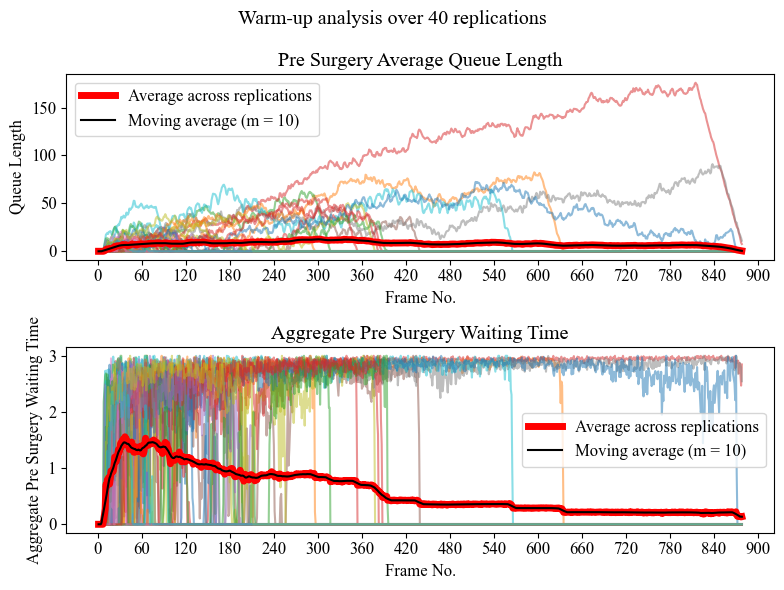

In [83]:

# Initialize parameters
num_of_replications = 40
num_of_days = 110
frame_length = 3  # hour
window_size = 10
tick_spacing = 60


# Set font and font size
mpl.rc('font', family='Times New Roman')
mpl.rc('font', size=12)

# Create an empty figure with two subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

# Set up a data structure to save required outputs in each replication
pre_surgery_waiting_time_frame_aggregate = dict()      # keys are replications
pre_surgery_average_queue_length_frame_aggregate = dict()      # keys are replications


# Function to calculate moving average of a list over a sliding window of length m.
def moving_average(input_list, m):
    output_list = []
    n = len(input_list)
    for i in range(n):
        output_list.append(sum(input_list[max(i - m // 2, 2 * i - n + 1, 0):min(i + m // 2 + 1, 2 * i + 1, n)]) / (
                min(i + m // 2, 2 * i, n - 1) - max(i - m // 2, 2 * i - n + 1, 0) + 1))
    return output_list


def calculate_aggregate_pre_surgery_queue_waiting_time(start_time, end_time, patients_data):
    patient_number = 0
    cumulative_pre_surgery_waiting_time = 0

    for patient in patients_data['Pre_surgery service begins']:
        # if the patient has arrived in this time-frame ...
        if start_time <= patients_data['presurgery_arrival'][patient] < end_time:
            # if the patient starts getting service in this time-frame...
            if patients_data['Pre_surgery service begins'][patient] < end_time:
                cumulative_pre_surgery_waiting_time += patients_data['Pre_surgery service begins'][patient] - patients_data['presurgery_arrival'][patient]
                patient_number += 1
            # else if the patient will start getting service after this time-frame...
            else:
                cumulative_pre_surgery_waiting_time += end_time - patients_data['presurgery_arrival'][patient]
                patient_number += 1
        # if the patient has arrived before the beginning of this time-frame
        # but starts getting service during this time-frame...
        elif start_time < patients_data['Pre_surgery service begins'][patient] < end_time:
            cumulative_pre_surgery_waiting_time += patients_data['Pre_surgery service begins'][patient] - start_time
            patient_number += 1
            
        elif patients_data['presurgery_arrival'][patient] < start_time and patients_data['Pre_surgery service begins'][patient] > end_time:
            cumulative_pre_surgery_waiting_time += end_time - start_time
            patient_number += 1
            
        elif patients_data['presurgery_arrival'][patient] > end_time:
            break

    if patient_number == 0:
        return 0
    
    return cumulative_pre_surgery_waiting_time / patient_number

def calculate_pre_surgery_average_Queue_Length(start_time, end_time, patients_data):
    cumulative_waiting_time = 0
    
    for patient in patients_data['Pre_surgery service begins']:
        # if the patient has arrived in this time-frame ...
        if start_time <= patients_data['presurgery_arrival'][patient] < end_time:
            # if the patient starts getting service in this time-frame...
            if patients_data['Pre_surgery service begins'][patient] < end_time:
                cumulative_waiting_time += patients_data['Pre_surgery service begins'][patient] - patients_data['presurgery_arrival'][patient]
            # else if the patient will start getting service after this time-frame...
            else:
                cumulative_waiting_time += end_time - patients_data['presurgery_arrival'][patient]
        # if the patient has arrived before the beginning of this time-frame
        # but starts getting service during this time-frame...
        elif start_time < patients_data['Pre_surgery service begins'][patient] < end_time:
            cumulative_waiting_time += patients_data['Pre_surgery service begins'][patient] - start_time
            
        elif patients_data['presurgery_arrival'][patient] < start_time and patients_data['Pre_surgery service begins'][patient] > end_time:
            cumulative_waiting_time += end_time - start_time
            
        elif patients_data['presurgery_arrival'][patient] > end_time:
            break

    return cumulative_waiting_time / (end_time - start_time)

simulation_time = num_of_days * 24
# Just use the frames with full information (drop last 2 frames)
num_of_frames = simulation_time // frame_length - 2
x = [i for i in range(1, num_of_frames + 1)]


for replication in range(1, num_of_replications + 1):

    simulation_data = simulation(num_of_days * 24)

    # print(simulation_data)
    patients_data = simulation_data['Patients']

    pre_surgery_average_queue_length_frame_aggregate[replication] = []
    pre_surgery_waiting_time_frame_aggregate[replication] = []

    # do calculations frame by frame
    for time in range(0, num_of_frames * frame_length, frame_length):
        pre_surgery_average_queue_length_frame_aggregate[replication].append(
           calculate_pre_surgery_average_Queue_Length(time, time + frame_length, patients_data))

        pre_surgery_waiting_time_frame_aggregate[replication].append(
            calculate_aggregate_pre_surgery_queue_waiting_time(time, time + frame_length, patients_data))

    # plot outputs in each replication
    ax[0].plot(x, pre_surgery_average_queue_length_frame_aggregate[replication], alpha=0.5)
    ax[1].plot(x, pre_surgery_waiting_time_frame_aggregate[replication], alpha=0.5)


pre_surgery_avg_queue_length_replication_average = []
pre_surgery_waiting_time_replication_average = []


for i in range(num_of_frames):
    pre_surgery_avg_queue_length = 0
    pre_surgery_average_waiting_time = 0

    for replication in range(1, num_of_replications + 1):
        pre_surgery_avg_queue_length += pre_surgery_average_queue_length_frame_aggregate[replication][i] * (1 / num_of_replications)
        pre_surgery_average_waiting_time += pre_surgery_waiting_time_frame_aggregate[replication][i] * (1 / num_of_replications)

    pre_surgery_avg_queue_length_replication_average.append(pre_surgery_avg_queue_length)
    pre_surgery_waiting_time_replication_average.append(pre_surgery_average_waiting_time)

pre_surgery_avg_queue_length_moving_replication_average = moving_average(pre_surgery_avg_queue_length_replication_average, window_size)
pre_surgery_waiting_time_moving_replication_average = moving_average(pre_surgery_waiting_time_replication_average, window_size)




fig.suptitle(f'Warm-up analysis over {num_of_replications} replications')

ax[0].plot(x, pre_surgery_avg_queue_length_replication_average, 'r', linewidth=5, label="Average across replications")
ax[0].plot(x, pre_surgery_avg_queue_length_moving_replication_average, 'k', label=f'Moving average (m = {window_size})')
ax[0].set_title('Pre Surgery Average Queue Length')
ax[0].set_xlabel('Frame No.')
ax[0].set_ylabel('Queue Length')
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[0].legend()

ax[1].plot(x, pre_surgery_waiting_time_replication_average, 'r', linewidth=5, label="Average across replications")
ax[1].plot(x, pre_surgery_waiting_time_moving_replication_average, 'k', label=f'Moving average (m = {window_size})')
ax[1].set_title('Aggregate Pre Surgery Waiting Time')
ax[1].set_xlabel('Frame No.')
ax[1].set_ylabel('Aggregate Pre Surgery Waiting Time')
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[1].legend()

fig.tight_layout()
fig.show()
fig.savefig('Hospital Simulation - Warm-up analysis - Time-Frame Approach')

<h2>Phase 3 / Second Warm Up Analysis</h2>

-------------------------------------------------------------------------------------------------
Simulation Ended!

=== Metrics Calculation Results ===

Average Queue Lengths:
  Reservation Queue: 0.0
  Patients in General Queue: 0.0

Average Waiting Times:
  Reservation Queue: 0.00
Bed Utilizations:
  CCU: 0.65%
-------------------------------------------------------------------------------------------------
Simulation Ended!

=== Metrics Calculation Results ===

Average Queue Lengths:
  Reservation Queue: 0.0
  Patients in General Queue: 0.0

Average Waiting Times:
  Reservation Queue: 0.00
Bed Utilizations:
  CCU: 1.20%
-------------------------------------------------------------------------------------------------
Simulation Ended!

=== Metrics Calculation Results ===

Average Queue Lengths:
  Reservation Queue: 40.25776927178327
  Patients in General Queue: 71.4471551101843

Average Waiting Times:
  Reservation Queue: 3158.27
Bed Utilizations:
  CCU: 56.38%
---------------------

C:\Users\Mahshad\AppData\Local\Temp\ipykernel_3496\2843977199.py:148: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


-------------------------------------------------------------------------------------------------
Simulation Ended!

=== Metrics Calculation Results ===

Average Queue Lengths:
  Reservation Queue: 1.3567501187266782
  Patients in General Queue: 4.151728216604403

Average Waiting Times:
  Reservation Queue: 271.35
Bed Utilizations:
  CCU: 13.37%
-------------------------------------------------------------------------------------------------
Simulation Ended!

=== Metrics Calculation Results ===

Average Queue Lengths:
  Reservation Queue: 2.351181067878844
  Patients in General Queue: 3.585407533540252

Average Waiting Times:
  Reservation Queue: 0.00
Bed Utilizations:
  CCU: 6.83%
-------------------------------------------------------------------------------------------------
Simulation Ended!

=== Metrics Calculation Results ===

Average Queue Lengths:
  Reservation Queue: 0.0
  Patients in General Queue: 0.0

Average Waiting Times:
  Reservation Queue: 0.00
Bed Utilizations:
  CCU

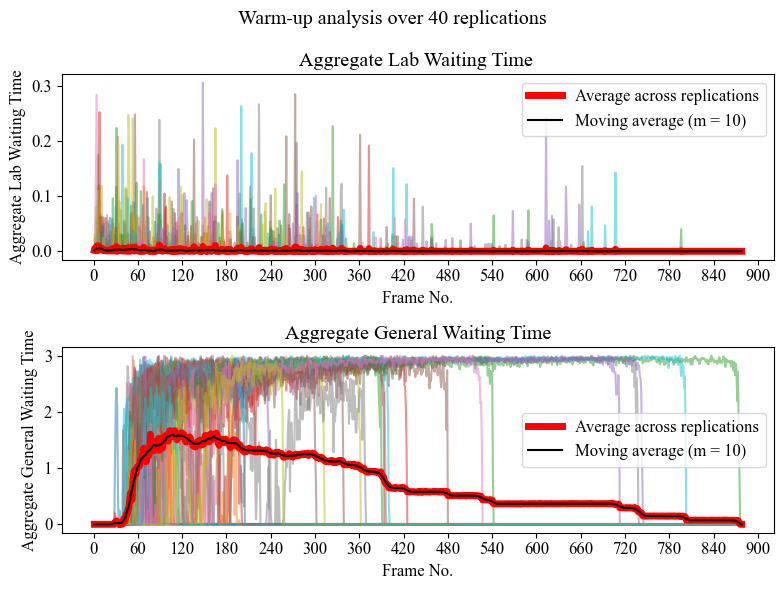

In [85]:

# Set font and font size
mpl.rc('font', family='Times New Roman')
mpl.rc('font', size=12)

# Create an empty figure with two subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

# Set up a data structure to save required outputs in each replication
general_waiting_time_frame_aggregate = dict()      # keys are replications
lab_waiting_time_frame_aggregate = dict()      # keys are replications



def calculate_aggregate_lab_queue_waiting_time(start_time, end_time, patients_data):
    patient_number = 0
    cumulative_lab_waiting_time = 0

    for patient in patients_data['Lab service begins']:
        # if the patient has arrived in this time-frame ...
        if start_time <= patients_data['Lab_arrival'][patient] < end_time:
            # if the patient starts getting service in this time-frame...
            if patients_data['Lab service begins'][patient] < end_time:
                cumulative_lab_waiting_time += patients_data['Lab service begins'][patient] - patients_data['Lab_arrival'][patient]
                patient_number += 1
            # else if the patient will start getting service after this time-frame...
            else:
                cumulative_lab_waiting_time += end_time - patients_data['Lab_arrival'][patient]
                patient_number += 1
        # if the patient has arrived before the beginning of this time-frame
        # but starts getting service during this time-frame...
        elif start_time < patients_data['Lab service begins'][patient] < end_time:
            cumulative_lab_waiting_time += patients_data['Lab service begins'][patient] - start_time
            patient_number += 1
            
        elif patients_data['Lab_arrival'][patient] < start_time and patients_data['Lab service begins'][patient] > end_time:
            cumulative_lab_waiting_time += end_time - start_time
            patient_number += 1
            
        elif patients_data['Lab_arrival'][patient] > end_time:
            break

    if patient_number == 0:
        return 0
    
    return cumulative_lab_waiting_time / patient_number


def calculate_aggregate_general_waiting_time(start_time, end_time, patients_data):
    patient_number = 0
    cumulative_general_waiting_time = 0

    for patient in patients_data['General service begins']:
        # if the patient has arrived in this time-frame ...
        if start_time <= patients_data['General_arrival'][patient] < end_time:
            # if the patient starts getting service in this time-frame...
            if patients_data['General service begins'][patient] < end_time:
                cumulative_general_waiting_time += patients_data['General service begins'][patient] - patients_data['General_arrival'][patient]
                patient_number += 1
            # else if the patient will start getting service after this time-frame...
            else:
                cumulative_general_waiting_time += end_time - patients_data['General_arrival'][patient]
                patient_number += 1
        # if the patient has arrived before the beginning of this time-frame
        # but starts getting service during this time-frame...
        elif start_time < patients_data['General service begins'][patient] < end_time:
            cumulative_general_waiting_time += patients_data['General service begins'][patient] - start_time
            patient_number += 1
            
        elif patients_data['General_arrival'][patient] < start_time and patients_data['General service begins'][patient] > end_time:
            cumulative_general_waiting_time += end_time - start_time
            patient_number += 1
            
        elif patients_data['General_arrival'][patient] > end_time:
            break

    if patient_number == 0:
        return 0
    
    return cumulative_general_waiting_time / patient_number


x = [i for i in range(1, num_of_frames + 1)]


for replication in range(1, num_of_replications + 1):

    simulation_data = simulation(num_of_days * 24)

    # print(simulation_data)
    patients_data = simulation_data['Patients']

    lab_waiting_time_frame_aggregate[replication] = []
    general_waiting_time_frame_aggregate[replication] = []

    # do calculations frame by frame
    for time in range(0, num_of_frames * frame_length, frame_length):
        lab_waiting_time_frame_aggregate[replication].append(
           calculate_aggregate_lab_queue_waiting_time(time, time + frame_length, patients_data))

        general_waiting_time_frame_aggregate[replication].append(
            calculate_aggregate_general_waiting_time(time, time + frame_length, patients_data))

    # plot outputs in each replication
    ax[0].plot(x, lab_waiting_time_frame_aggregate[replication], alpha=0.5)
    ax[1].plot(x, general_waiting_time_frame_aggregate[replication], alpha=0.5)


lab_waiting_time_replication_average = []
general_waiting_time_replication_average = []


for i in range(num_of_frames):
    lab_average_waiting_time = 0
    general_average_waiting_time = 0

    for replication in range(1, num_of_replications + 1):
        lab_average_waiting_time += lab_waiting_time_frame_aggregate[replication][i] * (1 / num_of_replications)
        general_average_waiting_time += general_waiting_time_frame_aggregate[replication][i] * (1 / num_of_replications)

    lab_waiting_time_replication_average.append(lab_average_waiting_time)
    general_waiting_time_replication_average.append(general_average_waiting_time)

lab_average_waiting_time_moving_replication_average = moving_average(lab_waiting_time_replication_average, window_size)
general_waiting_time_moving_replication_average = moving_average(general_waiting_time_replication_average, window_size)




fig.suptitle(f'Warm-up analysis over {num_of_replications} replications')

ax[0].plot(x, lab_waiting_time_replication_average, 'r', linewidth=5, label="Average across replications")
ax[0].plot(x, lab_average_waiting_time_moving_replication_average, 'k', label=f'Moving average (m = {window_size})')
ax[0].set_title('Aggregate Lab Waiting Time ')
ax[0].set_xlabel('Frame No.')
ax[0].set_ylabel('Aggregate Lab Waiting Time')
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[0].legend()

ax[1].plot(x, general_waiting_time_replication_average, 'r', linewidth=5, label="Average across replications")
ax[1].plot(x, general_waiting_time_moving_replication_average, 'k', label=f'Moving average (m = {window_size})')
ax[1].set_title('Aggregate General Waiting Time')
ax[1].set_xlabel('Frame No.')
ax[1].set_ylabel('Aggregate General Waiting Time')
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[1].legend()

fig.tight_layout()
fig.show()
#fig.savefig('Hospital Simulation - Warm-up analysis - Time-Frame Approach')
#%%                                Phase 3 / Q3   ===> Independent Sampling

# Number of first system replication
R1 = 45
for i in range(R1):
    simulation(110*24)
    
import pickle 
with open('data.pkl', 'wb') as file:
    pickle.dump(metric_dict_System1, file)    